# 核密度估计

密度评估器是一种利用D维数据集生成D维概率分布估计的算法  
核密度估计，是将高斯混合理念扩展到了逻辑极限，他会对__每个点生成高斯分布的混合成分__，从而获得本质上是无参数的密度评估器

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## KDE 的由来：直方图

直方图相当于一维数据的密度估计

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x


x = make_data(1000)

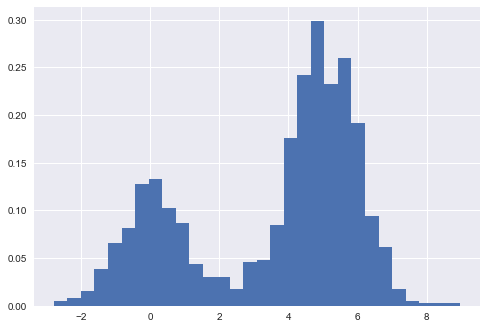

In [3]:
hist = plt.hist(x, bins=30,  density = True) # 标准化，让直方图的总面积 = 1

In [4]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

使用直方图作为密度评估器的缺点：
* 区间大小和位置的选择不同，产生的统计特征也不同

In [5]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

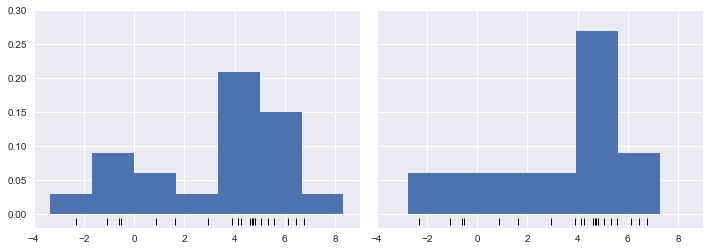

In [6]:
fig, ax = plt.subplots(
    1,
    2,
    figsize=(12, 4),
    sharex=True,
    sharey=True,
    subplot_kw={
        'xlim': (-4, 9),
        'ylim': (-0.02, 0.3)
    })

fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)

那么如何相信一个直方图的可视化结果？   
* 将直方图看做是一个个方块，直方图是各种方块在固定区域的叠加

(-0.2, 8)

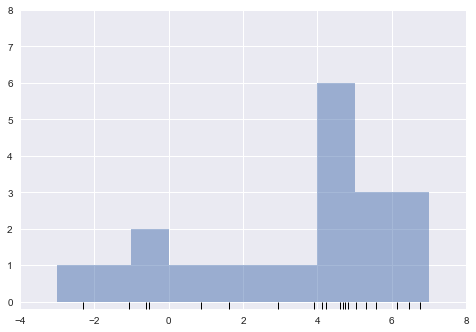

In [7]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k',
       markeredgewidth=1)
for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1,
                                  alpha=0.5))

ax.set_xlim(-4, 8)
ax.set_ylim(-0.2, 8)
# 这个直方图是一个个方块叠上去的

之所以会造成解读差异，主要原因是方块堆叠的高度通常不能反应区间附近数据点的实际密度。  
换句话说，数据点与每个方块是没有对齐的  
此时我们想到如果所有的方块都是与某个数据点对齐的话，就能比较好的表达出密度

[-4, 8, -0.2, 8]

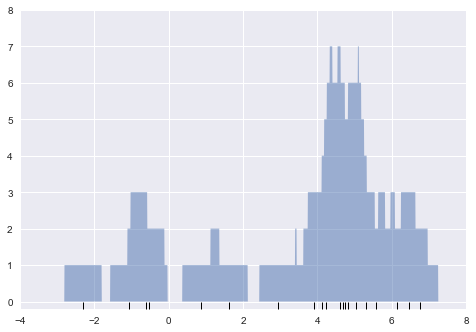

In [8]:
# 将间隔切的很小
x_d = np.linspace(-4, 8, 2000)
# 对于每一个小间隔的点，在该点的周围长度1的单位里，有多少个数在其中（用的是对True的计数）
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha = 0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8])

虽然看上去有点乱，但是和标准的直方图相比，这幅图可以更全面的反映出数据的真实特征,就是有点不美观   
我们可以用平滑函数取代每个位置上的方块，例如使用高斯函数，下面利用正态分布曲线代替每个点的方块

[-4, 8, -0.2, 8]

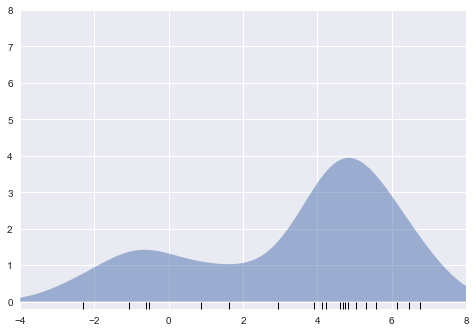

In [9]:
from scipy.stats import norm

x_d = np.linspace(-4, 8, 1000)

# 对每个点，都假设是正态分布得到的点，均值为 x_i
density = sum(norm(x_i).pdf(x_d) for x_i in x)

plt.fill_between(x_d, density, alpha = 0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8])

以上两幅图是核密度估计在一维中的示例，第一幅图用的是“tophat”，第二幅图用的是“高斯核”

## 核密度估计的实际应用

有点像是，针对每个点，都假设有一种相同的分布，最终这些分布汇总成一个总的分布  
核密度估计的自由参数，是 ‘核类型’，其可以指定每个点核密度分布的形状  
‘核带宽’ 控制的是每个点的核的大小   
sklearn 中 KDE 支持六种核   
由于KDE计算量非常大，所以sklearn评估器底层使用了一种基于树的算法，可以利用 atol 和 rtol 参数来平衡计算时间与准确性  
另外我们也可以利用标准的交叉检验工具来确定自有参数的带宽

(-0.02, 0.22)

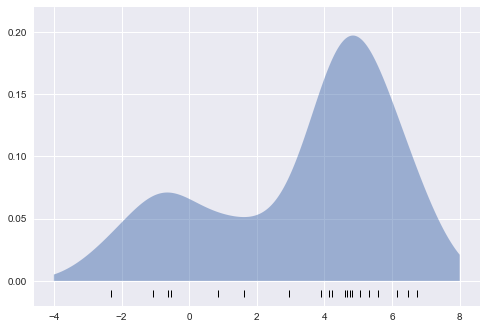

In [10]:
from sklearn.neighbors import KernelDensity

# 初始化并拟合KDE模型
kde = KernelDensity(bandwidth=1, kernel = 'gaussian')
kde.fit(x[:,None])

# score_samples 返回概率密度的对数值
logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

这里经过了标准化处理，保证曲线下的面积为1

### 通过交叉检验选择带宽

带宽过窄将导致估计高方差，也就是过拟合，出来的数据大都是原数据  
带宽过宽将导致估计高偏差，也就是欠拟合，而且带宽较大的核还会破坏核的数据结构

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                   {'bandwidth': bandwidths},
                   cv=LeaveOneOut())
grid.fit(x[:, None])

GridSearchCV(cv=LeaveOneOut(), error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bandwidth': array([  0.1    ,   0.10476, ...,   9.54548,  10.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

## 球形空间的KDE

KDE其实最常用于描述数据点的分布。例如在seaborn可视化库中，KDE是内置画图函数，可以自动对一维和二维空间的数据进行可视化  

Basemap 这个包比较捉鸡，感觉安装很不人性化，就不尝试安装了

## 示例： 不是很朴素的贝叶斯

在朴素贝叶斯中，生成模型是与坐标轴平行的高斯分布。  
如果底层用KDE来做核密度估计算法，我们就可能用更成熟的生成模型描述每一个类。虽然他还是贝叶斯分类，但是不是 naive的了

以下是用sklearn的框架，使用网格搜索和交叉检验来实现以上想法

In [13]:
from sklearn.base import BaseEstimator, ClassifierMixin


# 复制了一个评估器的必要逻辑，可以用于交叉检验，另外Classifier定义了一个score的方法，可以用来交叉检验
class KDEClassifier(BaseEstimator, ClassifierMixin):
    """基于KDE的贝叶斯生成分类
    
    参数
    ------------------------
    bandwidth: float
        每个类中的核带宽
    kernel: str
        核函数的名称
    """
    def __init__(self, bandwidth=1.0, kernel='gaussian'):
        '''
        在sklearn中，除了将参数值传递给self之外，初始化不包含任何操作，因为BaseEstimator 的逻辑需要满足用于交叉检验、
        网格搜索和其他功能的评估器的复制与修改需求
        __init__ 中的所有参数都是显式的，不允许使用 *args 或者 **kwargs， 因为这些可变参数在交叉检验方法中无法被正确理解
        '''
        self.bandwidth = bandwidth
        self.kernel = kernel
        
    def fit(self, X, y):
        self.classes_ = np.sort(np.unique(y))
        training_sets = [X[y == yi] for yi in self.classes_]
        # 为每个类别，训练一个KDE，得到每个类别的核密度估计
        self.models_ = [KernelDensity(bandwidth=self.bandwidth,
                                     kernel=self.kernel).fit(Xi)
                       for Xi in training_sets]
        # 权重对数化，也就是类的先验概率
        self.logpriors_ = [np.log(Xi.shape[0] / X.shape[0])
                          for Xi in training_sets]
        # 之所以要return self ，是为了串联所有命令，可以链式
        return self
    
    def predict_proba(self, X):
        '''计算X属于每个model的赋权概率'''
        logprobs = np.array([model.score_samples(X)
                            for model in self.models_]).T
        result = np.exp(logprobs + self.logpriors_)
        return result / result.sum(1, keepdims=True)
    
    def predict(self, X):
        '''取概率值最大'''
        return self.classes_[np.argmax(self.predict_proba(X), axis = 1)]

In [14]:
# 使用自定义评估器

from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV

digits = load_digits()

bandwidths = 10 ** np.linspace(0,2,100)
grid = GridSearchCV(KDEClassifier(), {'bandwidth':bandwidths})
grid.fit(digits.data, digits.target)

scores = grid.cv_results_['mean_test_score']

{'bandwidth': 7.0548023107186433}
accuracy = 0.966611018364


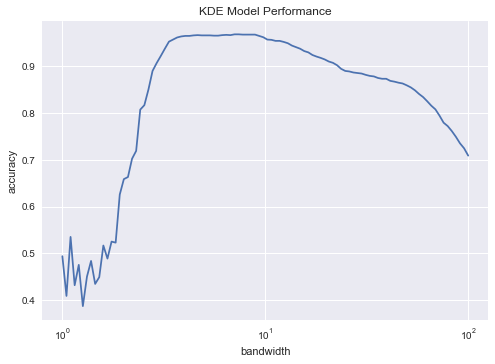

In [15]:
# 很坐标是对数坐标
plt.semilogx(bandwidths, scores)
plt.xlabel('bandwidth')
plt.ylabel('accuracy')
plt.title('KDE Model Performance')
print(grid.best_params_)
print('accuracy =', grid.best_score_)

我们发现这个分类器的准确率能到达 96%
朴素贝叶斯仅仅只有 80%

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), digits.data, digits.target).mean()

0.81860038035501381